In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp 
from random import choice 
import networkx as nx


$$ \begin{bmatrix}
rcos(\theta + \psi + \omega t) & -rsin(\theta + \psi + \omega t)\\
rsin(\theta + \psi + \omega t) & rcos(\theta + \psi + \omega t)\\
\end{bmatrix}
$$ 
$$ = $$
$$ e^{i\theta}e^{i\psi}e^{i\omega t}    $$

Iterate rotation 
$$ e^{i\theta_{t+1}} = e^{i\omega t}e^{i(\theta_{t}+\psi)
}$$

Laplace oscillator:
$$ e^{st} = e^{\lambda}e^{i\omega t}$$ 
Giving a damped oscillator
Making this fall into a resting state may be challegning
I would also like them to have some kind of action potential, but thats for later.

Goals 
- two oscillators influence one another 
- Create network
- explore hebbian
- explore dkl



In [33]:
from numpy import zeros_like
from numpy import pi, cos, sin

class Network: 
    def __init__(self,N) -> None:
        self.N = N
        self.Nodes = {}
        for i in range(N): # builds the network - needs power law for location and natfreq - needs Gaussian/uniform for phase.
            self.Nodes[i] = Oscillator(2,pi*i,0,[i,0,0])
        self.adjacency = np.zeros([N,N])
        self.coupling = np.zeros([N,N])
        

    def Connect(self,a,P_inhib):
        # -a is power law exponent
        for i in range(self.N-1):
            for j in range(i+1,self.N): 
                if j != i:
                    pool = np.zeros([10000,1])
                    inhib_pool = np.ones([10000,1])
                    xi = self.Nodes[i].location
                    xj = self.Nodes[j].location 
                    s = np.abs(xi-xj)
                    mag = np.sqrt(s[0]**2 + s[1]**2 + s[2]**2 )
                    prob_connect = 1/(mag**a+1) # connection law. +1 is offset to normalise ## CHANGE to control connectivity
                    connect_num = np.round(len(pool)*prob_connect)
                    pool[1:int(connect_num)] = 1
                    np.random.shuffle(pool)
                    inhib_num = np.round(len(pool)*P_inhib)
                    pool[1:int(inhib_num)] = -1
                    np.random.shuffle(inhib_pool)
                    self.coupling[i,j] = (1/mag)*pool[np.random.randint(0,len(pool))]*inhib_pool[np.random.randint(0,len(pool))]
                    self.coupling[j,i] = (1/mag)*pool[np.random.randint(0,len(pool))]*inhib_pool[np.random.randint(0,len(pool))]
                else:
                    continue


                # pick ith oscillator. Include self connections???? 
    def Manual_connect(self,node1,node2,weight):
        self.adjacency[node1,node2] = weight
    def Adjacency(self,graph): # for networkx
        self.adjacency = graph
        
    def Run(self, time):
        # runs network
        self.state = np.zeros([len(time),1,self.N]) # Time series of XY for each oscillator n 
        for t in time: 
            # Build influence vector containing the effect of coupled oscillators on their downstreams
            I = np.dot(self.adjacency,self.state) # dots two and adds them
            for i in range(self.N): #fro each oscillator
                # look at all neighbours and interact with correct oscillator
                self.Nodes[i].Spin(t)
                






class Oscillator:
    def __init__(self,r,nat,phase,location) -> None:
        self.nat = nat 
        self.theta = phase
        self.r = 1
        self.location = location
        self.current =  r*cos(self.theta) + r*sin(self.theta)*1j # [[r*cos(phase),r*sin(phase)],[-r*sin(phase),r*cos(phase)]] # starts at non zero location

    # def Connect(self,dist):
    #     self.connections

    def Spin(self,t):
        # LEFT HAND MULTIPLY - Matrix mult doesnt commute - WX /= XW
        theta_now = self.nat*t+self.theta
        self.current = self.r*cos(theta_now) +self.r*sin(theta_now)*1j
        return self.current

        
    

In [34]:
test = Oscillator(0.5,-2*pi,pi,[0,0,0])

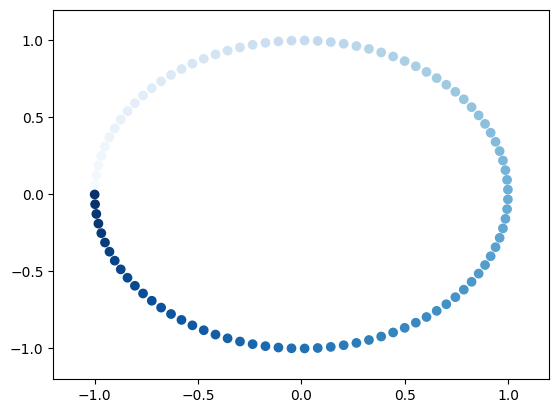

In [35]:
time = np.linspace(0,1,num=100)

i = 0
results=len(time)*[None]
for t in time:
    results[i] = test.Spin(t)
    i += 1

# extract real part
x = [ele.real for ele in results]
# extract imaginary part
y = [ele.imag for ele in results]

plt.scatter(x,y, c=range(0,len(results)), cmap=plt.get_cmap('Blues')) # 1:0.1:len
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.show()

In [36]:
# Connect two oscillators

test2 = Oscillator(0.9,pi,0,[1,0,0])



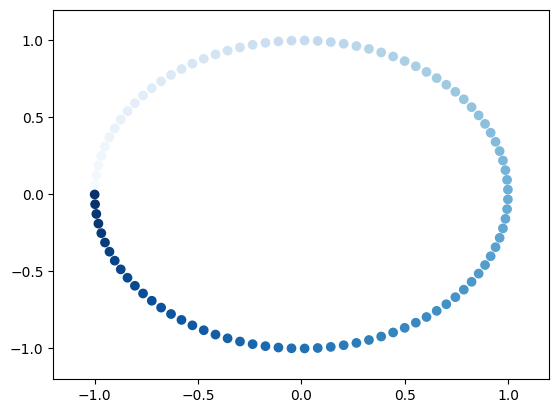

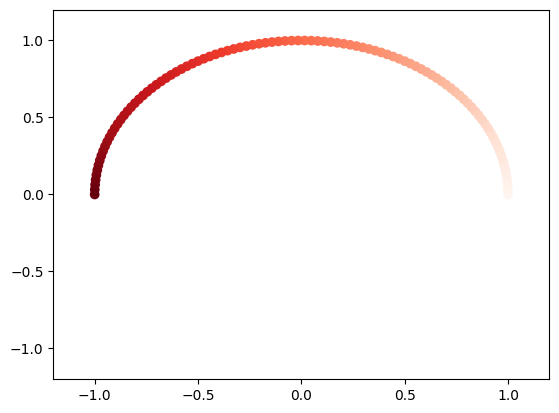

In [43]:
time = np.linspace(0,1,num=100)

i = 0
results=len(time)*[None]
results2=len(time)*[None]
for t in time:
    results[i] = test.Spin(t)
    results2[i] = test2.Spin(t)
    i += 1


XY = np.zeros((len(results),2))
# extract real part
x = [ele.real for ele in results]
# extract imaginary part
y = [ele.imag for ele in results]


plt.scatter(x,y, c=range(0,len(results)), cmap=plt.get_cmap('Blues')) # 1:0.1:len

plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.show()
x = [ele.real for ele in results2]
# extract imaginary part
y = [ele.imag for ele in results2]
plt.scatter(x,y , c=range(0,len(results)), cmap=plt.get_cmap('Reds')) # 1:0.1:len
plt.xlim([-1.2,1.2])
plt.ylim([-1.2,1.2])
plt.show()

In [38]:
Netty = Network(50)

In [39]:
Netty.Nodes[1].location 



[1, 0, 0]

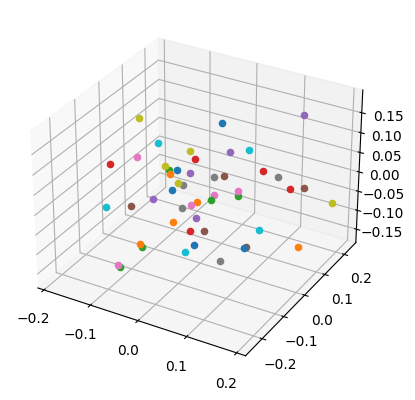

In [40]:
# Put nodes spatially distrubuted with a distribution
# Gaussian dist 
a = 1 # currently for pink law
mu, sigma = 0, 0.1
for i in range(len(Netty.Nodes)):
    x = np.random.normal(mu,sigma,1)
    y = np.random.normal(mu,sigma,1)
    z = np.random.normal(mu,sigma,1)
    Netty.Nodes[i].location = np.array([x,y,z])

#plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(Netty.Nodes)):
    ploot = Netty.Nodes[i].location
    ax.scatter(ploot[0],ploot[1],ploot[2])

In [41]:
# connect nodes probabilistically, plot 
# using a power law distribution Prob(connect) = 1/dist 
# so adjacency matrix is built using this
Netty.Connect(1)


TypeError: Network.Connect() missing 1 required positional argument: 'P_inhib'

In [ ]:
# coupling strengths proportional to distance#
# plt lines and weight by magnitude
time = np.linspace(0,1,num=100)
Netty.Run(time)